# Машинное обучение ДЗ 3

Данное дз копия https://github.com/yandexdataschool/Practical_DL/blob/fall19/week05_nlp/part2_pytorch.ipynb

Однако содержит дополнительные задания на применение tf-idf и bag-of-words. 

# Natural Language Processing with Deep Learning

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [3]:
data = pd.read_csv("kaggle/dz/Train_rev1.csv", index_col=None)

# Добавляем логарифм зарплаты
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
66234,68712797,Profit Analyst,Responsible for the delivery of core analytica...,Basingstoke Hampshire South East,Basingstoke,NaN,permanent,COMPUTER 2000,IT Jobs,"From 23,000 to 28,000 per annum PLUS 25% Bonus...",25500,totaljobs.com,10.146473
168577,71333374,Clinical Training Low Intensity IAPT Associat...,(Ref. P****) This fulltime post is available *...,South West England,South West England,NaN,NaN,University of Exeter,Teaching Jobs,"25,582 . pro rata",25582,Jobs Ac,10.149683
12455,66553103,RFP Exec,The role will involve completing RFP's / RFI's...,London,London,NaN,NaN,Mirage Recruitment,Accounting & Finance Jobs,Circa 40k - 50k pro-rata,45000,eFinancialCareers,10.714440


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [4]:
print("Before")
print(data["Title"][::10000])

Before
0                               Engineering Systems Analyst
10000                            Optometrist Job Canterbury
20000                                     Security officers
30000                                           Night Nurse
40000                                   App Developer (iOS)
50000     Smart Metering Project Manager (Complex Networ...
60000                                        Office Manager
70000                             Internal Sales Negotiator
80000                                     Contracts Manager
90000                     Structural Design Engineer  Dubai
100000                                         HR Assistant
110000    Senior Solutions Architect  Bellshill, North L...
120000                                          Lead Tester
130000                           Treasury Assistant/Cashier
140000           Deputy Manager Cool NEW GASTRO PUB Concept
150000     Programmes Director  Global Defence Organisation
160000         Assessor/Tutor  Re

In [5]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# Мы берем каждый столбец с текстовыми признаками
# И делаем так, чтобы между любыми символами, кроме объединений слов стоял пробел

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [6]:
print("After")
print(data["Title"][::10000])

After
0                               engineering systems analyst
10000                            optometrist job canterbury
20000                                     security officers
30000                                           night nurse
40000                                 app developer ( ios )
50000     smart metering project manager ( complex netwo...
60000                                        office manager
70000                             internal sales negotiator
80000                                     contracts manager
90000                      structural design engineer dubai
100000                                         hr assistant
110000    senior solutions architect bellshill , north l...
120000                                          lead tester
130000                         treasury assistant / cashier
140000           deputy manager cool new gastro pub concept
150000      programmes director global defence organisation
160000        assessor / tutor ret

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()

# Считает, сколько раз каждый токен появляется в "Title" и "FullDescription"
# Для каждого текста из объединенного вектора всех текстов
for text in np.hstack([data.FullDescription.values, data.Title.values]):
    # Разбиваем предложение на токены
    tokens = tokenizer.tokenize(text)
    
    # Для каждого токена ведём счёт
    for token in tokens:
        token_counts[token] += 1

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


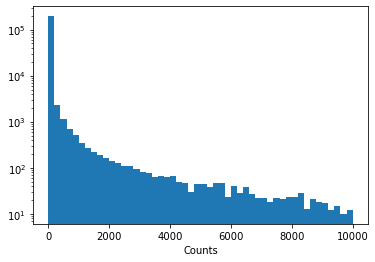

In [9]:
# Посмотрим, сколько слов встречаются от 0 до 10000 раз

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts");

# Анализ данных и TF-IDF (3 балла)

В данном задании вам необходимо реализовать TF-IDF.

Использование готовых реализаций запрещено.

### Задание 1.1 (1 балл)
Возьмите топ 20% наиболее оплачиваемых вакансий и топ 20% наименее оплачиваемых вакансий.

В каждом классе посчитайте частоту слов.

Напечатайте топ 20 слов из каждого класса

In [11]:
top_twenty = data.sort_values(by=['SalaryNormalized'], ascending = False).iloc[:int(0.2 * len(data)), :]
least_twenty = data.sort_values(by=['SalaryNormalized'], ascending = True).iloc[:int(0.2 * len(data)), :]

In [12]:
top_twenty_c = Counter()
least_twenty_c = Counter()

# Считает, сколько раз каждый токен появляется в "Title"
# Для каждого текста из вектора всех заголовков
for text in top_twenty.Title.values:
    # Разбиваем предложение на токены
    tokens = tokenizer.tokenize(text)
    
    # Для каждого токена ведём счёт
    for token in tokens:
        top_twenty_c[token] += 1 / len(tokens)

# То же самое для второго класса
for text in least_twenty.Title.values:
    # Разбиваем предложение на токены
    tokens = tokenizer.tokenize(text)
    
    # Для каждого токена ведём счёт
    for token in tokens:
        least_twenty_c[token] += 1 / len(tokens)

In [14]:
from pprint import pprint
print('Для первого класса')
pprint(top_twenty_c.most_common(20))
print('-'*10)

print('Для второго класса')
pprint(least_twenty_c.most_common(20))

Для первого класса
[('manager', 3862.4939578152466),
 ('senior', 1551.5804894983141),
 ('engineer', 1250.0886998736833),
 ('/', 1076.7991668518014),
 ('developer', 943.636024457475),
 (',', 848.7848933742188),
 ('business', 758.0552357014112),
 ('project', 714.1654720694509),
 ('****', 706.2574350298762),
 ('analyst', 681.7984268784195),
 ('director', 582.9874490061017),
 ('consultant', 562.7691138926419),
 ('sales', 521.9977427800937),
 ('london', 470.3863391451932),
 ('of', 458.7794776201868),
 ('(', 452.51760879309757),
 ('financial', 442.8946886446861),
 ('finance', 439.7037979564265),
 (')', 438.556531383011),
 ('development', 436.58088659705993)]
----------
Для второго класса
[('assistant', 2229.7359416726995),
 ('administrator', 1470.897836885334),
 ('sales', 1292.7848720723662),
 ('manager', 972.2551258382229),
 ('/', 960.6904585537674),
 ('support', 941.2078241203394),
 ('cleaner', 759.5398268398292),
 ('worker', 632.7267260517264),
 ('customer', 628.5180911479795),
 ('executi

### Задание 1.2 (2 балла)

Возьмите топ 20% наиболее оплачиваемых вакансий и топ 20% наименее оплачиваемых вакансий. 

В каждом классе посчитайте суммарный tf-idf для каждого слова

Напечатайте топ 20 слов из каждого класса

### Для 20% наиболее оплачиваемых вакансий

In [15]:
# IDF термина а = логарифм(Общее количество документов / Количество документов, в которых встречается термин а)
import tqdm
titles = top_twenty['Title']
# Каждый отдельный заголовок - это новый документ
all = len(titles)

# Для каждого слова, которое встречалось в топ-20 заголовках
for word in tqdm.tqdm(top_twenty_c):
    # Обнуляем счетчик
    counte = 0
    # Для каждого заголовка из всех заголовков
    for title in titles:
        # Для каждого слова внутри одного заголовка
        for wor in title.split(' '):
            # Если слово внутри заголовка совпадает со словом, из топ 20
            if word == wor:
                # То увеличиваем счетчик на 1
                counte +=1
    # Пройдя все заголовки для одного слова, считаем idf и tf-idf
    idf = np.log(all / counte)
    # Перезаписываем в словарь подсчитанный tf-idf, вместо tf
    top_twenty_c[word] = top_twenty_c[word] * idf


100%|██████████████████████████████████████████████████████████████████████████████| 7885/7885 [06:14<00:00, 21.07it/s]


In [16]:
pprint(top_twenty_c.most_common(20))

[('manager', 4692.091349689706),
 ('senior', 3047.05911613155),
 ('engineer', 2879.278594197559),
 ('developer', 2264.4961441832124),
 ('project', 2027.5090820536136),
 ('business', 2026.2702322287266),
 ('analyst', 1961.8362550471738),
 ('/', 1917.008202529264),
 ('director', 1800.243444401045),
 ('consultant', 1677.8359798405006),
 ('sales', 1574.6806794818146),
 ('financial', 1536.0521075483196),
 ('finance', 1528.747311241569),
 ('****', 1518.8560049259465),
 (',', 1503.9092323010982),
 ('of', 1423.1104737332369),
 ('development', 1392.3653285154926),
 ('head', 1338.8264863700872),
 ('london', 1281.6097826448363),
 ('accountant', 1258.9049230264504)]


### Для 20% наименее оплачиваемых вакансий

In [17]:
titles = least_twenty['Title']
# Каждый отдельный заголовок - это новый документ
all = len(titles)

# Для каждого слова, которое встречалось в худших-20% заголовках
for word in tqdm.tqdm(least_twenty_c):
    # Обнуляем счетчик
    counte = 0
    # Для каждого заголовка из всех заголовков
    for title in titles:
        # Для каждого слова внутри одного заголовка
        for wor in title.split(' '):
            # Если слово внутри заголовка совпадает со словом, из худших-20%
            if word == wor:
                # То увеличиваем счетчик на 1
                counte +=1
    # Пройдя все заголовки для одного слова, считаем idf и tf-idf
    idf = np.log(all / counte)
    # Перезаписываем в словарь подсчитанный tf-idf, вместо tf
    least_twenty_c[word] = least_twenty_c[word] * idf

100%|██████████████████████████████████████████████████████████████████████████████| 8072/8072 [05:37<00:00, 23.88it/s]


In [18]:
pprint(least_twenty_c.most_common(20))

[('assistant', 4266.492335873799),
 ('administrator', 3905.378680538865),
 ('sales', 2955.609115358434),
 ('cleaner', 2894.000737801721),
 ('manager', 2613.605238452556),
 ('support', 2486.7705636080336),
 ('/', 2105.0807590111363),
 ('executive', 1979.0397139262006),
 ('worker', 1945.3887268186631),
 ('customer', 1863.0681777876719),
 ('care', 1803.098551545821),
 ('service', 1801.7150314645928),
 ('advisor', 1793.4676502433686),
 ('operative', 1596.7671842366285),
 ('chef', 1520.845085955498),
 ('receptionist', 1502.4705440358396),
 ('consultant', 1460.591788863895),
 ('coordinator', 1408.6830744866954),
 ('accounts', 1403.3550076510771),
 ('labourer', 1376.0684111367218)]


# Bag of words (3 балла)

В данном задании вам необходимо построить регрессию поверх bag-of-words

Можно использовать любые библиотеки

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model

# Создаём bag of words из всего датасета, чтобы для каждого слова был ключ в словаре
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(data['Title'])

# Разбиваем выборку на обучающую и отложенную
train_, test_, train_labels, test_labels = train_test_split(data['Title'], data['Log1pSalary'])

# Переводим разбитую подвыборку, представленную в виде текста в векторный формат
train_ = vectorizer.transform(train_.values) 
test_ = vectorizer.transform(test_.values) 

# Строим регрессия по bag of words
clf = linear_model.LinearRegression().fit(train_, train_labels)
pred = clf.predict(test_)

# Оцениваем построенную регрессию
print('Показатель качества подгонки регрессии составил: {:3.2f}'.format(r2_score(test_labels, pred)))

Показатель качества подгонки регрессии составил: 0.57


# Нейросетевой подход (4 балла)

Вам необходимо сделать весь оставшийся ноутбук.


enjoy :)

__Task 1.1__ Получите список всех токенов, которые встречаются хотя бы 10 раз.

In [15]:
min_count = 10

# Выбираем те токены, которые встречались не менее определенного порога раз
tokens = [token for token, count in token_counts.items() if count >= min_count] 

# Просто добавляем токены для неизвестных и пустых слов
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Постройте обратный словарь (из индексов в токены)

In [17]:
token_to_id = {token: index for index, token in enumerate(tokens)}

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


Используем словарь, который мы только что построили, чтобы представить данные в удобный для торча формат.

In [19]:
# В переменные помещаем индексы соответствующих токенов
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    """ Конвертируем список токенов в матрицу с отступом """
    if isinstance(sequences[0], str):
        # Разбиваем каждое предложение на слова и создаем список слов из строк
        sequences = list(map(str.split, sequences))
    # Определяем длину строки. Она либо максимум из количества слов во всех строках, либо установленное число
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    # Создаем матрицу, размера (количество ппредложений Х максимальную длину предложения) и заполняем её пустыми словами
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    # Для номера, предложения в предложениях:
    for i, seq in enumerate(sequences):
        # Новая строка - индекс слова, если оно новое, то UNKNOWN для всех слов из строки
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        # Заменяем в матрице строку нашей
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  548  2361     1     1     1]
 [  537 10662   390   307    32]]


Теперь давайте закодируем наши категориальные признаки.

Как обычно для простоты мы будем использовать one-hot кодирование. Можно применять другие техники: (tf-idf, target averaging or pseudo-counter-based encoding)

In [21]:
from sklearn.feature_extraction import DictVectorizer

# Рассмотрим только топ 1000 самых частых компаний, чтобы сэкономить потребление памяти
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part
Как только мы научились токенезировать данные, пора устраивать эксперимент.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [23]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Создает совместимый с пайторчем словарь из батча данных
    Возвращает: словарь с {'title' : int64[batch, title_max_len]}
    
    """
    # Если указан размет батча
    if batch_size is not None:
        # То из данных берем подвыборку размерностью батча
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    # Для каждого столбца, содержащего текст
    for col in text_columns:
        # Засовываем в словарь матричное представление всего столбца данных
        batch[col] = as_matrix(data[col].values, max_len)
    # Категориальный вектор также засовываем под отдельный ключ
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [24]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 2980,  7005,     1,     1,     1,     1,     1,     1,     1,
             1],
        [ 3714,  7896,  2712,   130,  1398,     1,     1,     1,     1,
             1],
        [ 3906,    58,  1362,    89,   417,   270,   130, 17226,   130,
          1340]]),
 'FullDescription': array([[  49,  171,   46, 2980, 7005,  130, 4503,  103,  533,  119],
        [  10,   11,   15,  183,  458,    2,  186,   14, 2529,  309],
        [3906,   58, 1098,   89,  417, 3906,  867,   22,   89,   21]]),
 'Categorical': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.351927,  9.639587, 10.434145], dtype=float32)}

### Приступаем к нейронным сетям

Наша модель состоит из 3-х веток
* Энкодер заголовка
* Энкодер описания
* Энкодер категориальных признаков

После создания этих веток, мы скормим нейронке эти данные, чтобы предсказывать зарплату

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

По стандарту, оба текстовых векторайзера используют 1D convolutions, за которыми следует global pooling.


By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [25]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Сделаем так, чтобы работала быстро моя нейроночка
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [55]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        Простой энкодер последовательности для заголовков
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        
        # Сначала создаем слой, который каждому вектору из bag of words сопоставит вектор
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.bn1 = nn.BatchNorm1d(out_size)
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: батч размера   [batch_size, max_len]
        :returns: батч другого размера [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # Меняем порядок размерности [batch, time, units] на [batch, units, time] чтобы соответствовать порядку Conv1d
        h = torch.transpose(h, 1, 2)
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        h = self.conv1(h)
        h = F.relu(self.pool1(h))
        h = F.relu(self.bn1(h))
        h = self.dense(h)
        return h

In [56]:
title_encoder = TitleEncoder(out_size=64).to(device)

# Мы взяли три случайных заголовка, сгенерировали из них батчи по принципу bag of words
dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title'])).to(device)

# А уже эти батчи мы проводили полностью через энкодер
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [57]:
# Придумайте энкодер для описания работы
    
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.rnn = nn.LSTM(input_size=64, hidden_size=90, num_layers=1, bidirectional=True, batch_first=True) 
        self.pool = GlobalMaxPooling(dim=1)
        self.dense = nn.Linear(200, out_size)

    def forward(self, text_ix, hidden=None):
        h = self.emb(text_ix)
        output, hidden = self.rnn(h, hidden)
        h = self.pool(output)
        h = self.dense(h)
        return h

In [58]:
desc_encoder = DescEncoder(out_size=64).to(device)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x.to(device))

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Постройте нейросеть ~~чтобы управлять ими~~

In [59]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size=64)
        
        # Придумай слои для категорильных признаков. Несколько полносвязных сойдет.
        # <YOUR CODE>
        self.dense1 = nn.Linear(n_cat_features, 128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, 32)
        
        # Придумай слой "выхода", который обработает все остальные модули нейросети
        #<YOUR CODE>
        self.output = nn.Linear(160, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # Проведи каждую дату по соответсвующим энкодерам
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # Примени категориальный энкодер
        cat_h = F.relu(self.dense1(cat_features))
        cat_h = F.relu(self.dense2(cat_h))
        cat_h = self.dense3(cat_h)
        
        
        # Соедини все матрицы вместе
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... и добавь парочку слоев еще
        output = self.output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        # Просто хотим избавиться от лишнего измерения
        return output[:, 0]

In [60]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
# Протестируем на батче
batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

# Предсказания для батча (поэтому вектор из 32 штучек)
prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [62]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [63]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [64]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [71]:
num_epochs = 20
max_len = 100
batch_size = 64
batches_per_epoch = 100

In [72]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference, prediction).data.cpu().numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.cpu().numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


d:\python\venvs\new_project\env\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':



	Loss:	0.10393
	MAE:	3141.76187



Validation:



	Loss:	0.09100
	MAE:	2859.38650



Training:



	Loss:	0.09865
	MAE:	3002.18761



Validation:



	Loss:	0.08952
	MAE:	2842.63298



Training:



	Loss:	0.10218
	MAE:	3093.40226



Validation:



	Loss:	0.09214
	MAE:	2946.02167



Training:



	Loss:	0.09330
	MAE:	2870.86170



Validation:



	Loss:	0.08779
	MAE:	2823.89131



Training:



	Loss:	0.09755
	MAE:	2979.42778



Validation:



	Loss:	0.09350
	MAE:	2976.75328



Training:



	Loss:	0.09804
	MAE:	3061.73939



Validation:



	Loss:	0.08548
	MAE:	2781.91590



Training:



	Loss:	0.10164
	MAE:	3111.21841



Validation:



	Loss:	0.08651
	MAE:	2790.35756



Training:



	Loss:	0.09878
	MAE:	3005.97292



Validation:



	Loss:	0.10171
	MAE:	3020.85235



Training:



	Loss:	0.09060
	MAE:	2874.40453



Validation:



	Loss:	0.13521
	MAE:	3482.00354



Training:



	Loss:	0.09755
	MAE:	2987.95694



Validation:



	Loss:	0.08645
	MAE:	2785.25128



Training:



	Loss:	0.08946
	MAE:	2838.89897



Validation:



	Loss:	0.08543
	MAE:	2767.11811



Training:



	Loss:	0.09401
	MAE:	2889.32100



Validation:



	Loss:	0.10064
	MAE:	2984.89072



Training:



	Loss:	0.09104
	MAE:	2896.68809



Validation:



	Loss:	0.08571
	MAE:	2806.91695



Training:



	Loss:	0.08922
	MAE:	2887.73614



Validation:



	Loss:	0.08431
	MAE:	2821.35125



Training:



	Loss:	0.08864
	MAE:	2882.40104



Validation:



	Loss:	0.08435
	MAE:	2800.38023



Training:



	Loss:	0.09334
	MAE:	2964.35309



Validation:



	Loss:	0.10445
	MAE:	3264.38879



Training:



	Loss:	0.10200
	MAE:	3101.24911



Validation:



	Loss:	0.08504
	MAE:	2766.03915



Training:



	Loss:	0.09668
	MAE:	2903.89885



Validation:



	Loss:	0.08149
	MAE:	2696.04259



Training:



	Loss:	0.08751
	MAE:	2900.14717



Validation:



	Loss:	0.08111
	MAE:	2714.63821



Training:



	Loss:	0.08729
	MAE:	2835.90796



Validation:



	Loss:	0.08228
	MAE:	2703.82597





### 30 epochs MAE < 2800

In [73]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference, prediction).data.cpu().numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


d:\python\venvs\new_project\env\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':



	Loss:	0.08228
	MAE:	2703.82597





### Бонусная секция. Любые разумные попытки улучшить архитектуру поощряются дополнительными баллами. Чтобы мы не пропустили ваши старания - опишите ниже, что вы сделали (это должно быть видно и в коде). (max 4 балла).


### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

# Мои приколюхи

    1) Я добавил LSTM в DescriptionEncoder
    2) Добавил Батч нормализацию